In [1]:
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import urllib
from PIL import Image
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [3]:

loader = DataLoader(TensorDataset(data), batch_size =200, shuffle=True)

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")


GPU


In [4]:

class SinusoidalEmbedding(nn.Module):
  def __init__(self, size: int, scale: float = 1.0):
    super().__init__()
    self.size = size
    self.scale = scale

  def forward(self, x: torch.Tensor):
    x = x * self.scale
    half_size = self.size // 2
    emb = torch.log(torch.Tensor([10000.0]).to(device)) / (half_size - 1)
    emb = torch.exp(-emb * torch.arange(half_size).to(device))
    emb = x.unsqueeze(-1) * emb.unsqueeze(0)
    emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
    return emb

  def __len__(self):
    print(self.size)
    return self.size



In [15]:
class ConvBlock(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(ConvBlock, self).__init__()
    self.block = nn.Sequential(
        #use bias=False when you use BatchcNorm
        nn.Conv2d(in_channel, out_channel, kernel_size = (3,3), stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel, kernel_size = (3,3), stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.block(x)

In [17]:
import torchvision.transforms.functional as TF

class UNet(nn.Module):
  def __init__(self, in_channel, out_channel, img_size, channels = [64, 128, 256, 512]):
    super(UNet, self).__init__()
    self.img_size = img_size
    self.emb = SinusoidalEmbedding(self.img_size **2).to(device)

    # Up and down convolutional layers
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    for c in channels:
      self.downs.append(ConvBlock(in_channel, c))
      in_channel = c

    self.bottleneck = ConvBlock(channels[-1], channels[-1]*2)

    for c in reversed(channels):
      self.ups.append(
          nn.ConvTranspose2d(c*2, c, kernel_size=(2,2), stride=2)
      )
      self.ups.append(ConvBlock(c*2, c))

    self.final = nn.Conv2d(channels[0], out_channel, kernel_size=(1,1))

  def forward(self, x, t):
    t = t.expand(x.size(0))
    t_ = self.emb(t)
    x = torch.cat((x, t_), dim = -1)

    connections = []
    for down in self.downs:
      x = down(x)
      connections.append(x)
      x = self.pooling(x)

    x = self.bottleneck(x)

    connections = connections[::-1]
    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      jump = connections[idx // 2]
      concat_skip = torch.cat((jump, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    x = self.final(x)
    return x


In [5]:
class MLP(nn.Module):
  def __init__(self, emb_size):
    super(MLP, self).__init__()
    self.emb = SinusoidalEmbedding(emb_size).to(device)
    self.backbone = nn.Sequential(
        nn.Linear(2+ emb_size, 512),
        nn.LeakyReLU(),
        nn.Linear(512, 512),
        nn.LeakyReLU(),
        nn.Linear(512, 2)
    )

  def forward(self, x, t):
    t = t.expand(x.size(0))
    t_ = self.emb(t)
    x = torch.cat((x, t_), dim = -1)
    return self.backbone(x)

In [9]:
# Hyper parameters
num_epochs = 10
time_embedding_size = 128
lr = 1e-4


#T = 1000
#record_idx=[1,100,200,300,400,500,600,700,800,900,999]

T = 500
record_idx = [1, 100, 200, 300, 400, 499]

fwd = {t: [] for t in record_idx}
rev = {t: [] for t in record_idx}

# model, optimizer, loss
model = MLP(time_embedding_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
mse_loss = torch.nn.MSELoss()

# set time, beta, alpha, alpha_bar
beta = torch.linspace(1e-3, 1e-1, T).pow(2).to(device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sigma_t = torch.empty(T, device= device)
sigma_t[0] = 0
sigma_t[1:] = (1-alpha[:-1]) / (1-alpha_bar[1:]) * beta[1:]

# Training
for epoch in tqdm(range(num_epochs)):
  for idx, (x_in,) in enumerate(loader):
    for t in range(T):
      optimizer.zero_grad()

      x_in = x_in.to(device)
      eps = torch.randn_like(x_in)
      x_t = torch.sqrt(alpha_bar[t]) * x_in + torch.sqrt(1 - alpha_bar[t]) * eps

      eps_predicted = model(x_t, torch.tensor(t).to(device))
      loss = torch.norm(eps - eps_predicted)**2

      loss.backward()
      optimizer.step()

      if t in record_idx:
        fwd[t].append(x_t.detach().cpu())

# Sampling
x_t = torch.randn((2000,2)).to(device)

with torch.no_grad():
  for t in reversed(range(T)):
    if t > 0:
      eps = torch.randn_like(x_t)
    else:
      eps = torch.zeros_like(x_t)
    pred_eps = model(x_t, torch.tensor([t], device=device))

    x_t_1 = (1/torch.sqrt(alpha[t])) * (x_t- ((1-alpha[t]) / torch.sqrt(1-alpha_bar[t])) * pred_eps) + (torch.sqrt(sigma_t[t]) * eps)
    x_t = x_t_1

    if t in record_idx:
      rev[t].append(x_t.detach().cpu())


100%|██████████| 10/10 [01:40<00:00, 10.05s/it]


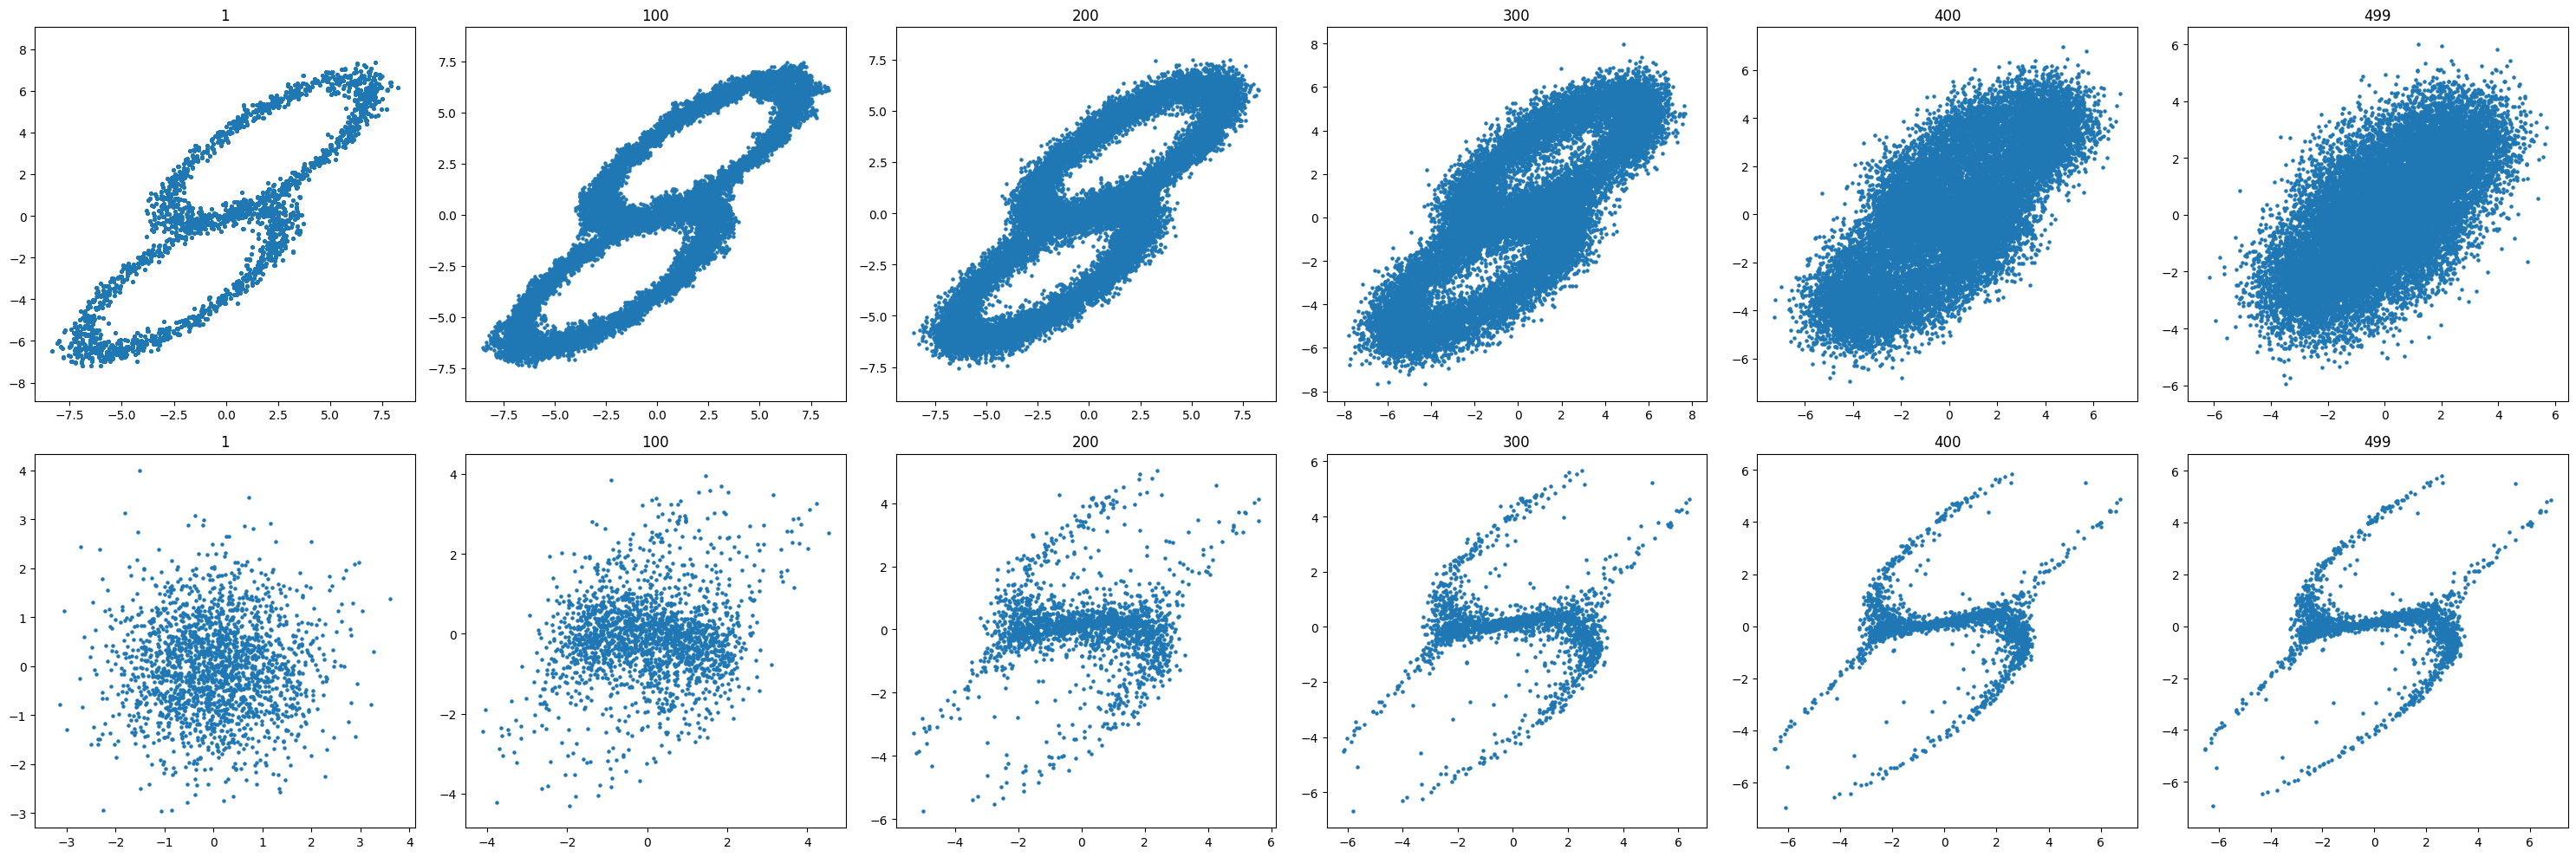

In [10]:
fig, axes = plt.subplots(2, len(record_idx), figsize=(30,10))
for r in range(2):
  for i, t in enumerate(record_idx):
    ax = axes[r, i]
    X=fwd[t] if r==0 else rev[record_idx[-1-i]]
    if X:
        X = torch.cat(X, dim=0)
        ax.scatter(X[:,0], X[:,1], s=5)
    ax.set_title(f'{t}')
    ax.axis('equal')

plt.tight_layout()
plt.show()